In [1]:
import numpy as np

# Chemical Drawing
from rdkit.Chem import MolFromMolBlock, MolToMolBlock, MolToMolFile, MolToSmiles, AddHs
from rdkit import Chem
from rdkit.Chem.AllChem import Compute2DCoords
from rdkit.Chem.Draw import MolToImage
from IPython.display import display
print(2)

import json
from utils import *
from tqdm import tqdm

# Lignin-KMC functions and global variables used in this notebook
from ligninkmc.kmc_functions import (run_kmc, generate_mol)
from ligninkmc.create_lignin import (calc_rates, create_initial_monomers, create_initial_events,
                                     create_initial_state, analyze_adj_matrix, adj_analysis_to_stdout)
from ligninkmc.kmc_common import (DEF_E_BARRIER_KCAL_MOL, ADJ_MATRIX, MONO_LIST, MONOMER, OX, GROW, Monomer, Event)

2


/home/tgog/.conda/envs/my-rdkit-env/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


_ColormakerRegistry()

### Lignin with guaiacyl monomers only

In [2]:
# change the 3 vars below
save_dir = "lignins_out"
num_monos = [1,2,3,4,5,6,7,8,9,10]
lignin_oligomers = []

# Calculate the rates of reaction in 1/s (or 1/monomer-s if biomolecular) at the specified temp
temp = 298.15  # K
rxn_rates = calc_rates(temp, ea_kcal_mol_dict=DEF_E_BARRIER_KCAL_MOL)

In [7]:
def prune_conformers(mol, tfd_thresh):
    """
    Prune conformers from a molecule using an RMSD threshold, starting
    with the lowest energy conformer.

    Parameters
    ----------
    mol : RDKit Mol
            Molecule.

    Returns
    -------
    new: A new RDKit Mol containing the chosen conformers, sorted by
             increasing energy.
    new_rmsd: matrix of conformer-conformer RMSD
    """
    if tfd_thresh < 0 or mol.GetNumConformers() <= 1:
        return mol
    
    energies = confgen.get_conformer_energies(mol)
    
    tfd = array_to_lower_triangle(Chem.TorsionFingerprints.GetTFDMatrix(mol, useWeights=False), True)
    print(tfd)
    sort = np.argsort(energies)  # sort by increasing energy
    keep = []  # always keep lowest-energy conformer
    discard = []

    for i in sort:
        # always keep lowest-energy conformer
        if len(keep) == 0:
            keep.append(i)
            continue

        # get RMSD to selected conformers
        this_tfd = tfd[i][np.asarray(keep, dtype=int)]
        # discard conformers within the RMSD threshold
        if np.all(this_tfd >= tfd_thresh):
            keep.append(i)
        else:
            discard.append(i)

    # create a new molecule to hold the chosen conformers
    # this ensures proper conformer IDs and energy-based ordering
    new = Chem.Mol(mol)
    new.RemoveAllConformers()
    conf_ids = [conf.GetId() for conf in mol.GetConformers()]
    for i in keep:
        conf = mol.GetConformer(conf_ids[i])
        new.AddConformer(conf, assignId=True)
        
    return new

In [8]:
confgen = ConformerGeneratorCustom(max_conformers=1, 
                 rmsd_threshold=None, 
                 force_field='mmff',
                 pool_multiplier=1)  

for n in tqdm(num_monos):
    # Set the percentage of S
    sg_ratio = 0
    pct_s = sg_ratio / (1 + sg_ratio)

    # Set the initial and maximum number of monomers to be modeled.
    ini_num_monos = 1
    max_num_monos = n

    # Maximum time to simulate, in seconds
    t_max = 1  # seconds
    mono_add_rate = 1e4  # monomers/second

    # Use a random number and the given sg_ratio to determine the monolignol types to be initially modeled
    monomer_draw = np.random.rand(ini_num_monos)
    initial_monomers = create_initial_monomers(pct_s, monomer_draw)

    # Initially allow only oxidation events. After they are used to determine the initial state, add 
    #     GROW to the events, which allows additional monomers to be added to the reaction at the 
    #     specified rate and with the specified ratio
    initial_events = create_initial_events(initial_monomers, rxn_rates)
    initial_state = create_initial_state(initial_events, initial_monomers)
    initial_events.append(Event(GROW, [], rate=mono_add_rate))

    # simulate lignin creation
    result = run_kmc(rxn_rates, initial_state,initial_events, n_max=max_num_monos, t_max=t_max, sg_ratio=sg_ratio)
    # using RDKit
    nodes = result[MONO_LIST]
    adj = result[ADJ_MATRIX]
    block = generate_mol(adj, nodes)
    mol = MolFromMolBlock(block)
#     # cap with hydrogens
#     mol = AddHs(mol)
    lignin_oligomers.append(mol)
    # save
    fn = save_dir + f"/{sg_ratio}sgr_{max_num_monos}monos.mol"
    Chem.AllChem.EmbedMultipleConfs(mol, numConfs=200, numThreads=-1)
    Chem.AllChem.MMFFOptimizeMoleculeConfs(mol, numThreads=-1)
    mol = prune_conformers(mol, 0.05)
    energys = confgen.get_conformer_energies(mol)
    standard = energys.min()
    total = np.sum(np.exp(-(energys-standard)))
    
    out = {
        'mol': Chem.MolToSmiles(mol, isomericSmiles=False),
        'standard': standard,
        'total': total
    }
    print(out)
    with open(fn, 'w') as fp:
        json.dump(out, fp)

 10%|█         | 1/10 [00:00<00:07,  1.16it/s]

[[0.         0.15960713 0.18091451 ... 0.24962141 0.1632426  0.25683544]
 [0.15960713 0.         0.14886248 ... 0.10610218 0.12338795 0.14352744]
 [0.18091451 0.14886248 0.         ... 0.0902412  0.16262747 0.11622109]
 ...
 [0.24962141 0.10610218 0.0902412  ... 0.         0.21078489 0.09052448]
 [0.1632426  0.12338795 0.16262747 ... 0.21078489 0.         0.15759203]
 [0.25683544 0.14352744 0.11622109 ... 0.09052448 0.15759203 0.        ]]
{'mol': 'COc1cc(C2OCC3C(c4ccc([O])c(OC)c4)OCC23)ccc1[O]', 'standard': 77.6828302591855, 'total': 1.2285805198047244}


 20%|██        | 2/10 [00:01<00:06,  1.23it/s]

[[0.         0.11611825 0.24160499 ... 0.19962425 0.19258105 0.25507291]
 [0.11611825 0.         0.19354527 ... 0.30131994 0.15951929 0.36395829]
 [0.24160499 0.19354527 0.         ... 0.321941   0.18843035 0.26495023]
 ...
 [0.19962425 0.30131994 0.321941   ... 0.         0.21286302 0.12381378]
 [0.19258105 0.15951929 0.18843035 ... 0.21286302 0.         0.25906936]
 [0.25507291 0.36395829 0.26495023 ... 0.12381378 0.25906936 0.        ]]
{'mol': 'COc1cc(C2OCC3C(c4ccc([O])c(OC)c4)OCC23)ccc1[O]', 'standard': 79.93709514984367, 'total': 1.0980005080257718}
[[0.         0.33320922 0.3432099  ... 0.23176975 0.26993445 0.24803094]
 [0.33320922 0.         0.36040025 ... 0.25305377 0.29561333 0.25611606]
 [0.3432099  0.36040025 0.         ... 0.35860326 0.23799431 0.25844467]
 ...
 [0.23176975 0.25305377 0.35860326 ... 0.         0.41902681 0.1416575 ]
 [0.26993445 0.29561333 0.23799431 ... 0.41902681 0.         0.30437541]
 [0.24803094 0.25611606 0.25844467 ... 0.1416575  0.30437541 0.     

 30%|███       | 3/10 [00:03<00:07,  1.02s/it]

{'mol': 'COc1cc(C(O)C(CO)Oc2ccc(C3OCC4C(c5ccc([O])c(OC)c5)OCC34)cc2OC)ccc1[O]', 'standard': 113.26155490203678, 'total': 1.0060667133764514}
[[0.         0.30452457 0.2573867  ... 0.29126629 0.19985811 0.2709732 ]
 [0.30452457 0.         0.26707739 ... 0.24540353 0.21741566 0.28439714]
 [0.2573867  0.26707739 0.         ... 0.15547505 0.26092672 0.23099289]
 ...
 [0.29126629 0.24540353 0.15547505 ... 0.         0.20480254 0.23934816]
 [0.19985811 0.21741566 0.26092672 ... 0.20480254 0.         0.20653678]
 [0.2709732  0.28439714 0.23099289 ... 0.23934816 0.20653678 0.        ]]


 40%|████      | 4/10 [00:05<00:09,  1.53s/it]

{'mol': 'COc1cc(C2Oc3c(OC)cc(C4Oc5c(OC)cc(C6OCC7C(c8ccc([O])c(OC)c8)OCC67)cc5C4CO)cc3C2CO)ccc1[O]', 'standard': 138.8741176843924, 'total': 3.6554158520796376}
[[0.         0.29456425 0.34669789 ... 0.31911038 0.29518191 0.42596807]
 [0.29456425 0.         0.21137052 ... 0.30831499 0.27128024 0.3514703 ]
 [0.34669789 0.21137052 0.         ... 0.37638915 0.37136326 0.31490988]
 ...
 [0.31911038 0.30831499 0.37638915 ... 0.         0.31374298 0.30825713]
 [0.29518191 0.27128024 0.37136326 ... 0.31374298 0.         0.28684827]
 [0.42596807 0.3514703  0.31490988 ... 0.30825713 0.28684827 0.        ]]


 50%|█████     | 5/10 [00:09<00:10,  2.19s/it]

{'mol': 'COc1cc(C(O)C(CO)Oc2ccc(C(O)C(CO)Oc3ccc(C=CCO)cc3OC)cc2OC)ccc1Oc1cc(C(O)C(CO)Oc2ccc(C=CCO)cc2OC)cc(OC)c1[O]', 'standard': 223.04954175823298, 'total': 1.0079317584905827}
[[0.         0.31770203 0.25349235 ... 0.32323732 0.26523255 0.28215199]
 [0.31770203 0.         0.20891326 ... 0.22812321 0.187522   0.2387866 ]
 [0.25349235 0.20891326 0.         ... 0.24813228 0.1733329  0.29443142]
 ...
 [0.32323732 0.22812321 0.24813228 ... 0.         0.28383061 0.28298588]
 [0.26523255 0.187522   0.1733329  ... 0.28383061 0.         0.24877086]
 [0.28215199 0.2387866  0.29443142 ... 0.28298588 0.24877086 0.        ]]


 60%|██████    | 6/10 [00:14<00:12,  3.18s/it]

{'mol': 'COc1cc(C2Oc3c(OC)cc(C4Oc5c(OC)cc(C6Oc7c(OC)cc(C8OCC9C(c%10cc(OC)c%11c(c%10)C(CO)C(c%10ccc([O])c(OC)c%10)O%11)OCC89)cc7C6CO)cc5C4CO)cc3C2CO)ccc1[O]', 'standard': 205.27965639521636, 'total': 1.7605920616017987}
[[0.         0.26926272 0.29030474 ... 0.32157956 0.30668666 0.29723608]
 [0.26926272 0.         0.36678448 ... 0.2429621  0.29717802 0.25113104]
 [0.29030474 0.36678448 0.         ... 0.32594233 0.2482116  0.29302539]
 ...
 [0.32157956 0.2429621  0.32594233 ... 0.         0.20749842 0.21517174]
 [0.30668666 0.29717802 0.2482116  ... 0.20749842 0.         0.23309066]
 [0.29723608 0.25113104 0.29302539 ... 0.21517174 0.23309066 0.        ]]


 70%|███████   | 7/10 [00:22<00:13,  4.42s/it]

{'mol': 'COc1cc(C(O)C(CO)Oc2ccc(C3Oc4c(OC)cc(C(O)C(CO)Oc5ccc(C6OCC7C(c8cc(OC)c9c(c8)C(CO)C(c8cc(OC)c%10c(c8)C(CO)C(c8ccc([O])c(OC)c8)O%10)O9)OCC67)cc5OC)cc4C3CO)cc2OC)ccc1[O]', 'standard': 269.58431475530983, 'total': 1.1289026090714367}
[[0.         0.30265056 0.30798587 ... 0.2469578  0.28562965 0.32665784]
 [0.30265056 0.         0.31227335 ... 0.25567077 0.22478747 0.20449367]
 [0.30798587 0.31227335 0.         ... 0.27246542 0.25270002 0.27744317]
 ...
 [0.2469578  0.25567077 0.27246542 ... 0.         0.25417588 0.24573223]
 [0.28562965 0.22478747 0.25270002 ... 0.25417588 0.         0.16383317]
 [0.32665784 0.20449367 0.27744317 ... 0.24573223 0.16383317 0.        ]]


 80%|████████  | 8/10 [00:32<00:12,  6.03s/it]

{'mol': 'COc1cc(C(O)C(CO)Oc2ccc(C3Oc4c(OC)cc(C5Oc6c(OC)cc(C7Oc8c(OC)cc(C9Oc%10c(OC)cc(C%11Oc%12c(OC)cc(C%13Oc%14c(OC)cc(C=CCO)cc%14C%13CO)cc%12C%11CO)cc%10C9CO)cc8C7CO)cc6C5CO)cc4C3CO)cc2OC)ccc1[O]', 'standard': 291.7107937121415, 'total': 1.220435303970272}
[[0.         0.29341131 0.25586497 ... 0.3692735  0.33474066 0.29302095]
 [0.29341131 0.         0.33492306 ... 0.34658316 0.29897684 0.23726547]
 [0.25586497 0.33492306 0.         ... 0.30604621 0.32267769 0.32364093]
 ...
 [0.3692735  0.34658316 0.30604621 ... 0.         0.24058185 0.33803454]
 [0.33474066 0.29897684 0.32267769 ... 0.24058185 0.         0.28413105]
 [0.29302095 0.23726547 0.32364093 ... 0.33803454 0.28413105 0.        ]]


 90%|█████████ | 9/10 [00:49<00:09,  9.38s/it]

{'mol': 'COc1cc(C2Oc3c(OC)cc(C(O)C(CO)Oc4ccc(C5Oc6c(OC)cc(C(O)C(CO)Oc7ccc(C8OCC9C(c%10ccc(OC(CO)C(O)c%11cc(OC)c%12c(c%11)C(CO)C(c%11cc(OC)c%13c(c%11)C(CO)C(c%11ccc([O])c(OC)c%11)O%13)O%12)c(OC)c%10)OCC89)cc7OC)cc6C5CO)cc4OC)cc3C2CO)ccc1[O]', 'standard': 365.5190474683205, 'total': 2.372861053962649}
[[0.         0.28135498 0.27247177 ... 0.25117255 0.20526187 0.29159932]
 [0.28135498 0.         0.26836466 ... 0.26221007 0.26958537 0.1995282 ]
 [0.27247177 0.26836466 0.         ... 0.23847038 0.29614708 0.25702856]
 ...
 [0.25117255 0.26221007 0.23847038 ... 0.         0.25395266 0.24844235]
 [0.20526187 0.26958537 0.29614708 ... 0.25395266 0.         0.30180058]
 [0.29159932 0.1995282  0.25702856 ... 0.24844235 0.30180058 0.        ]]


100%|██████████| 10/10 [01:31<00:00,  9.16s/it]

{'mol': 'COc1cc(C2Oc3c(OC)cc(C(O)C(CO)Oc4ccc(C5Oc6c(OC)cc(C7Oc8c(OC)cc(C9Oc%10c(OC)cc(C%11Oc%12c(OC)cc(C%13Oc%14c(OC)cc(C(O)C(CO)Oc%15ccc(C%16Oc%17c(OC)cc(C=CCO)cc%17C%16CO)cc%15OC)cc%14C%13CO)cc%12C%11CO)cc%10C9CO)cc8C7CO)cc6C5CO)cc4OC)cc3C2CO)ccc1[O]', 'standard': 382.67033806159293, 'total': 1.0580324272223227}


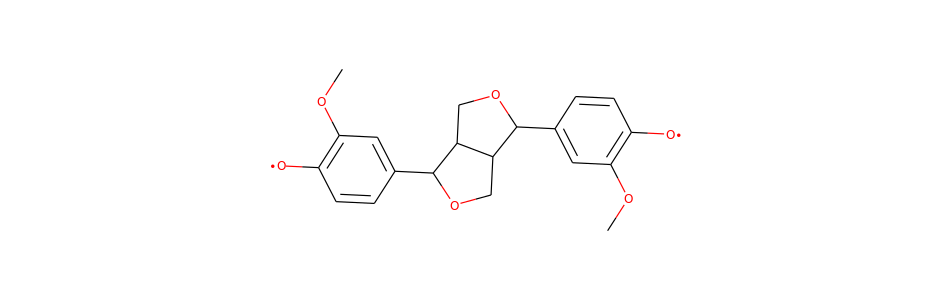

In [9]:
# display 2D
mol = lignin_oligomers[0]
Compute2DCoords(mol)
display(MolToImage(mol, size=(950, 300)))

In [13]:
import py3Dmol
def drawit(m, p, confId=-1):
    mb = MolToMolBlock(m, confId=confId)
    p.removeAllModels()
    p.addModel(mb, "sdf")
    p.setStyle({"stick":{}})
    p.setBackgroundColor("0xeeeeee")
    p.zoomTo()
    return p.show()

p = py3Dmol.view(width=800,height=800)
drawit(lignin_oligomers[9], p, confId=0)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

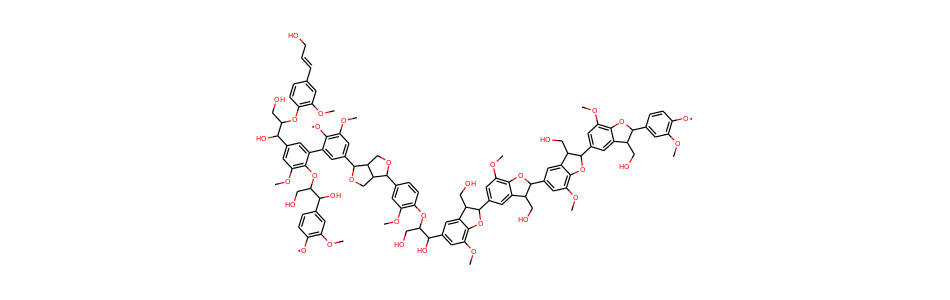

In [30]:
# display 2D
mol = lignin_oligomers[-1]
Compute2DCoords(mol)
display(MolToImage(mol, size=(950, 300)))

In [32]:
Chem.AllChem.EmbedMultipleConfs(mol, numConfs=1, numThreads=-1)
Chem.AllChem.MMFFOptimizeMoleculeConfs(mol, numThreads=-1)
drawit(mol, p, confId=0)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [20]:
conf = mol.GetConformers()[0]

In [23]:
conf.GetAtomPosition(0).x

-14.633322050588758